In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Métodos

In [2]:
#Metodo para alinear todos los datos de entrada
def create_dataframe(dataframe, path, files, features, max_rows):
    sorted_files = sorted(files)
    for file in sorted_files:
        df = pd.read_csv(path+file, sep=',', header=0, usecols=features)
        if(len(df.index)<max_rows):
            for i in range(len(df.index),max_rows):
                df = df.append(pd.Series(0, index=df.columns), ignore_index=True)
        else:
            for j in range(max_rows, len(df.index)):
                df = df.drop(j)            

        dataframe = dataframe.append(df, ignore_index=True)
    return dataframe

#Metodo para agrupar todas las etiquetas
def create_dataframe_label(dataframe, path, files):
    sorted_files = sorted(files)
    for file in sorted_files:
        df = pd.read_csv(path+file, sep=',', header=None)   
        dataframe = dataframe.append(df, ignore_index=True)
        
    output_array = dataframe.to_numpy()
    return output_array

#Metodo para generar datos adversos por medio de FGSM
def create_adversarial_pattern(time_series, y_true, model):
    with tf.GradientTape() as tape:
        tape.watch(time_series)
        prediction = model(time_series)
        loss = loss_object(y_true,prediction)
        gradient = tape.gradient(loss, time_series)
        signed_grad = tf.sign(gradient)
        return signed_grad

# Variables

In [3]:
#Datos para entrenamiento y prueba
path_training_x = '/home/luisk/Documents/ProyectoDiversificacion/training/'
path_training_y = '/home/luisk/Documents/ProyectoDiversificacion/training_label/'
path_test_x = '/home/luisk/Documents/ProyectoDiversificacion/test/'
path_test_y = '/home/luisk/Documents/ProyectoDiversificacion/test_label/'
files_training_x = os.listdir(path_training_x)
files_training_y = os.listdir(path_training_y)
files_test_x = os.listdir(path_test_x)
files_test_y = os.listdir(path_test_y)

#Caracteristicas a usar
features = ['ALP','ALT','AST','Age','Albumin','BUN','Bilirubin','Cholesterol',
     'Creatinine','DiasABP','FiO2','GCS','Gender0','Gender1','Glucose','HCO3',
     'HCT','HR','Height','ICUType1','ICUType2','ICUType3','ICUType4','K','Lactate',
     'MAP','MechVent','Mg','NIDiasABP','NIMAP','NISysABP','Na','PaCO2','PaO2',
     'Platelets','RespRate','SaO2','SysABP','Temp','TroponinI','TroponinT','Urine','WBC','Weight','pH']

#Datos para entrenamiento y prueba
path_adversarial_x = '/home/luisk/Documents/ProyectoDiversificacion/adversarial/'
path_adversarial_y = '/home/luisk/Documents/ProyectoDiversificacion/adversarial_label/'
files_adversarial_x = os.listdir(path_adversarial_x)
files_adversarial_y = os.listdir(path_adversarial_y)

# Preprocesamiento de los datos

In [4]:
#Datos de entrenamiento X
dataframe_training_x = pd.DataFrame()
dataframe_training_x = create_dataframe(dataframe_training_x, path_training_x,
                                       files_training_x,features, 99)
array_training_x = dataframe_training_x.to_numpy()
array_training_x = array_training_x.reshape(3200,99,45)

#Etiquetas de entrenamiento Y
dataframe_training_y = pd.DataFrame()
array_training_y = create_dataframe_label(dataframe_training_y, path_training_y,
                                       files_training_y)

#Datos de prueba X
dataframe_test_x = pd.DataFrame()
dataframe_test_x = create_dataframe(dataframe_test_x, path_test_x,
                                       files_test_x,features, 99)
array_test_x = dataframe_test_x.to_numpy()
array_test_x = array_test_x.reshape(800,99,45)

#Datos de prueba Y
dataframe_test_y = pd.DataFrame()
array_test_y = create_dataframe_label(dataframe_test_y, path_test_y,
                                       files_test_y)

# Entrenamiento Modelo A

In [5]:
model_a = tf.keras.models.Sequential()
model_a.add(tf.keras.layers.LSTM(100))
model_a.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model_a.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy', 'Precision', 'Recall'])
model_a.fit(array_training_x, array_training_y, epochs=10, batch_size=64)
print(model_a.summary())

Epoch 1/10
50/50 [==============================] - 4s 50ms/step - loss: 0.4473 - accuracy: 0.8634 - precision: 0.4444 - recall: 0.0092
Epoch 2/10
50/50 [==============================] - 3s 53ms/step - loss: 0.3942 - accuracy: 0.8637 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/10
50/50 [==============================] - 2s 48ms/step - loss: 0.3897 - accuracy: 0.8647 - precision: 1.0000 - recall: 0.0069
Epoch 4/10
50/50 [==============================] - 2s 49ms/step - loss: 0.3797 - accuracy: 0.8675 - precision: 0.7308 - recall: 0.0436
Epoch 5/10
50/50 [==============================] - 2s 50ms/step - loss: 0.3737 - accuracy: 0.8678 - precision: 0.6512 - recall: 0.0642
Epoch 6/10
50/50 [==============================] - 3s 52ms/step - loss: 0.3755 - accuracy: 0.8694 - precision: 0.7500 - recall: 0.0619
Epoch 7/10
50/50 [==============================] - 3s 51ms/step - loss: 0.3547 - accuracy: 0.8716 - precision: 0.6984 - recall: 0.1009
Epoch 8/10
50/50 [======================

# Entrenamiento Modelo B

In [6]:
model_b = tf.keras.models.Sequential()
model_b.add(tf.keras.layers.GRU(100))
model_b.add(tf.keras.layers.Dense(1,activation="sigmoid"))
model_b.compile(loss='poisson', optimizer='adam',metrics=['accuracy', 'Precision', 'Recall'])
model_b.fit(array_training_x, array_training_y, epochs=10, batch_size=64)
print(model_a.summary())

Epoch 1/10
50/50 [==============================] - 3s 43ms/step - loss: 0.4666 - accuracy: 0.8597 - precision: 0.3488 - recall: 0.0344
Epoch 2/10
50/50 [==============================] - 2s 42ms/step - loss: 0.3835 - accuracy: 0.8675 - precision: 0.6579 - recall: 0.0573
Epoch 3/10
50/50 [==============================] - 2s 41ms/step - loss: 0.3689 - accuracy: 0.8681 - precision: 0.5875 - recall: 0.1078
Epoch 4/10
50/50 [==============================] - 2s 42ms/step - loss: 0.3496 - accuracy: 0.8722 - precision: 0.7288 - recall: 0.0986
Epoch 5/10
50/50 [==============================] - 2s 44ms/step - loss: 0.3398 - accuracy: 0.8716 - precision: 0.6404 - recall: 0.1307
Epoch 6/10
50/50 [==============================] - 2s 42ms/step - loss: 0.3319 - accuracy: 0.8753 - precision: 0.6555 - recall: 0.1789
Epoch 7/10
50/50 [==============================] - 2s 40ms/step - loss: 0.3270 - accuracy: 0.8728 - precision: 0.5986 - recall: 0.2018
Epoch 8/10
50/50 [==============================

# Evaluación de los Modelos A y B con datos originales

### El articulo original define la puntuación como el minimo entre la precisión y la exhaustividad (recall). Por lo tanto,
### Score1 = min(precision, recall)
### Para efectos de referencia, durante la competencia de Physionet, el mejor Score1 fue de 0.53
### Para efectos de este proyecto, se tomará en cuenta el Valor F1 que combina ambas métricas

In [7]:
#Evaluacion Modelo A con datos originales
scores_a = model_a.evaluate(array_test_x, array_test_y, verbose=0)
accuracy = scores_a[1]*100
precision = scores_a[2]
recall = scores_a[3]
score_f1_a = 2*(precision*recall)/(precision+recall)
print("Exactitud: %.2f%%" %(accuracy))
print("Precisión: %.2f" %(precision))
print("Exhaustividad: %.2f" %(recall))
print("Valor F1: %.2f" %(score_f1_a)) 
print("Metrica de Physionet Score1: %.2f" %(min(precision,recall)))

Exactitud: 86.62%
Precisión: 0.87
Exhaustividad: 0.11
Valor F1: 0.20
Metrica de Physionet Score1: 0.11


In [8]:
#Evaluacion Modelo B con datos originales
scores_b = model_b.evaluate(array_test_x, array_test_y, verbose=0)
accuracy = scores_b[1]*100
precision = scores_b[2]
recall = scores_b[3]
score_f1_b = 2*(precision*recall)/(precision+recall)
print("Exactitud: %.2f%%" %(accuracy))
print("Precision: %.2f" %(precision))
print("Exhaustividad: %.2f" %(recall))
print("Valor F1: %.2f" %(score_f1_b)) 
print("Metrica de Physionet Score1: %.2f" %(min(precision,recall)))

Exactitud: 86.12%
Precision: 0.57
Exhaustividad: 0.24
Valor F1: 0.34
Metrica de Physionet Score1: 0.24


# Ataque # 1 - Se ataca al modelo A usando el ataque diseñado para modelo_A

In [9]:
#Funcion de perdida a usar en el ataque
loss_object = tf.keras.losses.binary_crossentropy

#Magnitud de la perturbacion Epsilon
array_adversarial_x = np.array
epsilon = 0.01

#Se atacan los mismos datos de prueba. Son 800 datos de prueba
signed_grad = create_adversarial_pattern(tf.convert_to_tensor(array_test_x),
                                       tf.convert_to_tensor(array_test_y), model_a)

temp = array_test_x + epsilon*signed_grad
data_adversarial_x_attack_1 = temp.numpy()

### Evaluación del Ataque # 1 - Se ataca al modelo A usando el ataque diseñado para modelo A

In [10]:
scores = model_a.evaluate(data_adversarial_x_attack_1, array_test_y, verbose=0)
accuracy = scores[1]*100
precision = scores[2]
recall = scores[3]
print("Exactitud: %.2f%%" %(accuracy))
print("Precision: %.2f" %(precision))
print("Exhaustividad: %.2f" %(recall))
print("Valor F1: %.2f" %(2*(precision*recall)/(precision+recall))) 
print("Metrica de Physionet Score1: %.2f" %(min(precision,recall)))

Exactitud: 83.13%
Precision: 0.23
Exhaustividad: 0.06
Valor F1: 0.09
Metrica de Physionet Score1: 0.06


# Ataque # 2 - Se ataca al modelo A, pero usando el ataque diseñado para modelo B

In [11]:
#Funcion de perdida a usar en el ataque
loss_object = tf.keras.losses.poisson

#Magnitud de la perturbacion Epsilon
array_adversarial_x = np.array
epsilon = 0.01

#Se atacan los mismos datos de prueba. Son 800 datos de prueba.
signed_grad = create_adversarial_pattern(tf.convert_to_tensor(array_test_x),
                                       tf.convert_to_tensor(array_test_y), model_b)

temp = array_test_x + epsilon*signed_grad
data_adversarial_x_attack_2 = temp.numpy()

### Evaluación del Ataque # 2 - Se ataca al modelo A, pero usando el ataque diseñado para modelo B

In [12]:
scores = model_a.evaluate(data_adversarial_x_attack_2, array_test_y, verbose=0)
accuracy = scores[1]*100
precision = scores[2]
recall = scores[3]
print("Exactitud: %.2f%%" %(accuracy))
print("Precision: %.2f" %(precision))
print("Exhaustividad: %.2f" %(recall))
print("Valor F1: %.2f" %(2*(precision*recall)/(precision+recall))) 
print("Metrica de Physionet Score1: %.2f" %(min(precision,recall)))

Exactitud: 84.50%
Precision: 0.35
Exhaustividad: 0.06
Valor F1: 0.10
Metrica de Physionet Score1: 0.06


# Ataque # 3 - Se ataca al modelo B, pero usando el ataque diseñado para modelo_A

In [13]:
#Funcion de perdida a usar en el ataque
loss_object = tf.keras.losses.binary_crossentropy

#Magnitud de la perturbacion Epsilon
array_adversarial_x = np.array
epsilon = 0.01

#Se atacan los mismos datos de prueba. Son 800 datos de prueba
signed_grad = create_adversarial_pattern(tf.convert_to_tensor(array_test_x),
                                       tf.convert_to_tensor(array_test_y), model_a)

temp = array_test_x + epsilon*signed_grad
data_adversarial_x_attack_3 = temp.numpy()

### Evaluación del Ataque # 3 - Se ataca al modelo B, pero usando el ataque diseñado para modelo A

In [14]:
scores = model_b.evaluate(data_adversarial_x_attack_3, array_test_y, verbose=0)
accuracy = scores[1]*100
precision = scores[2]
recall = scores[3]
print("Exactitud: %.2f%%" %(accuracy))
print("Precision: %.2f" %(precision))
print("Exhaustividad: %.2f" %(recall))
print("Valor F1: %.2f" %(2*(precision*recall)/(precision+recall))) 
print("Metrica de Physionet Score1: %.2f" %(min(precision,recall)))

Exactitud: 77.38%
Precision: 0.16
Exhaustividad: 0.13
Valor F1: 0.14
Metrica de Physionet Score1: 0.13


# Ataque # 4 - Se ataca al modelo B usando el ataque diseñado para modelo_B

In [15]:
#Funcion de perdida a usar en el ataque
loss_object = tf.keras.losses.poisson

#Magnitud de la perturbacion Epsilon
array_adversarial_x = np.array
epsilon = 0.01

#Se atacan los mismos datos de prueba. Son 800 datos de prueba
signed_grad = create_adversarial_pattern(tf.convert_to_tensor(array_test_x),
                                       tf.convert_to_tensor(array_test_y), model_b)

temp = array_test_x + epsilon*signed_grad
data_adversarial_x_attack_4 = temp.numpy()

### Evaluación del Ataque # 4 - Se ataca al modelo B usando el ataque diseñado para modelo B

In [16]:
scores = model_b.evaluate(data_adversarial_x_attack_4, array_test_y, verbose=0)
accuracy = scores[1]*100
precision = scores[2]
recall = scores[3]
print("Exactitud: %.2f%%" %(accuracy))
print("Precision: %.2f" %(precision))
print("Exhaustividad: %.2f" %(recall))
print("Valor F1: %.2f" %(2*(precision*recall)/(precision+recall))) 
print("Metrica de Physionet Score1: %.2f" %(min(precision,recall)))

Exactitud: 76.63%
Precision: 0.13
Exhaustividad: 0.10
Valor F1: 0.11
Metrica de Physionet Score1: 0.10


# Ataques en función de la intensidad de la perturbación (epsilon) - alta entropía

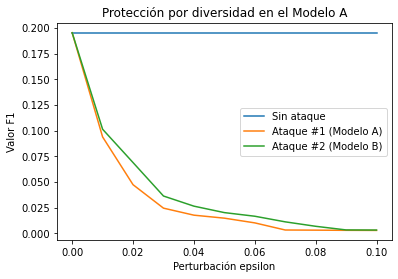

In [17]:
array_original = []
array_attack_1 = []
array_attack_2 = []
array_epsilon = []
relative_error_a_1 = []
relative_error_a_2 = []

for i in range(1,11):
    epsilon = 0.01*i
    loss_object = tf.keras.losses.binary_crossentropy
    array_adversarial_x = np.array
    signed_grad = create_adversarial_pattern(tf.convert_to_tensor(array_test_x),
                                           tf.convert_to_tensor(array_test_y), model_a)
    temp = array_test_x + epsilon*signed_grad
    data_adversarial_x = temp.numpy()
    scores = model_a.evaluate(data_adversarial_x, array_test_y, verbose=0)
    precision = scores[2]
    recall = scores[3]
    if(precision != 0 and recall != 0):
        score_f1 = 2*(precision*recall)/(precision+recall)
    else:
        score_f1 = 0
    relative_error = (score_f1 - score_f1_a)/score_f1_a    
     
    array_attack_1.append(score_f1) 
    array_epsilon.append(epsilon)
    array_original.append(score_f1_a)
    relative_error_a_1.append(relative_error)

for i in range(1,11):
    epsilon = 0.01*i
    loss_object = tf.keras.losses.poisson
    array_adversarial_x = np.array
    signed_grad = create_adversarial_pattern(tf.convert_to_tensor(array_test_x),
                                           tf.convert_to_tensor(array_test_y), model_b)
    temp = array_test_x + epsilon*signed_grad
    data_adversarial_x = temp.numpy()
    scores = model_a.evaluate(data_adversarial_x, array_test_y, verbose=0)
    precision = scores[2]
    recall = scores[3]
    if(precision != 0 and recall != 0):
        score_f1 = 2*(precision*recall)/(precision+recall)
    else:
        score_f1 = 0    
    relative_error = (score_f1 - score_f1_a)/score_f1_a
    
    array_attack_2.append(score_f1)
    relative_error_a_2.append(relative_error)

#Modelo A
array_original.insert(0,score_f1_a)
array_attack_1.insert(0,score_f1_a)
array_attack_2.insert(0,score_f1_a)
array_epsilon.insert(0,0)
plt.plot(array_epsilon,array_original , label='Sin ataque')
plt.plot(array_epsilon,array_attack_1 , label='Ataque #1 (Modelo A)')
plt.plot(array_epsilon,array_attack_2 , label='Ataque #2 (Modelo B)')
plt.xlabel("Perturbación epsilon")
plt.ylabel("Valor F1")
plt.title("Protección por diversidad en el Modelo A")
plt.legend()
plt.show()

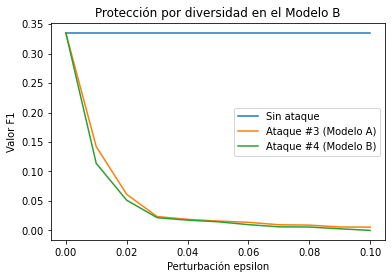

In [18]:
array_original = []
array_attack_3 = []
array_attack_4 = []
array_epsilon = []
relative_error_b_3 = []
relative_error_b_4 = []

for i in range(1,11):
    epsilon = 0.01*i
    loss_object = tf.keras.losses.binary_crossentropy
    array_adversarial_x = np.array
    signed_grad = create_adversarial_pattern(tf.convert_to_tensor(array_test_x),
                                           tf.convert_to_tensor(array_test_y), model_a)
    temp = array_test_x + epsilon*signed_grad
    data_adversarial_x = temp.numpy()
    scores = model_b.evaluate(data_adversarial_x, array_test_y, verbose=0)
    precision = scores[2]
    recall = scores[3]
    if(precision != 0 and recall != 0):
        score_f1 = 2*(precision*recall)/(precision+recall)
    else:
        score_f1 = 0
    relative_error = (score_f1 - score_f1_b)/score_f1_b
    
    array_attack_3.append(score_f1) 
    array_epsilon.append(epsilon)
    array_original.append(score_f1_b)
    relative_error_b_3.append(relative_error)

for i in range(1,11):
    epsilon = 0.01*i
    loss_object = tf.keras.losses.poisson
    array_adversarial_x = np.array
    signed_grad = create_adversarial_pattern(tf.convert_to_tensor(array_test_x),
                                           tf.convert_to_tensor(array_test_y), model_b)
    temp = array_test_x + epsilon*signed_grad
    data_adversarial_x = temp.numpy()
    scores = model_b.evaluate(data_adversarial_x, array_test_y, verbose=0)
    precision = scores[2]
    recall = scores[3]
    if(precision != 0 and recall != 0):
        score_f1 = 2*(precision*recall)/(precision+recall)
    else:
        score_f1 = 0
    relative_error = (score_f1 - score_f1_b)/score_f1_b
    
    array_attack_4.append(score_f1)
    relative_error_b_4.append(relative_error)

#Modelo B
array_original.insert(0,score_f1_b)
array_attack_3.insert(0,score_f1_b)
array_attack_4.insert(0,score_f1_b)
array_epsilon.insert(0,0)
plt.plot(array_epsilon,array_original , label='Sin ataque')
plt.plot(array_epsilon,array_attack_3 , label='Ataque #3 (Modelo A)')
plt.plot(array_epsilon,array_attack_4 , label='Ataque #4 (Modelo B)')
plt.xlabel("Perturbación epsilon")
plt.ylabel("Valor F1")
plt.title("Protección por diversidad en el Modelo B")
plt.legend()
plt.show()

# Se decide crear un modelo que permita mayor entropia

# Entrenamiento Modelo C

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [20]:
modelo_c = LogisticRegression(max_iter=1000).fit(array_training_x.reshape(3200,4455), array_training_y.reshape(3200))
y_pred = modelo_c.predict(array_test_x.reshape(800,4455))

modelo_c_accuracy = accuracy_score(array_test_y.reshape(800), y_pred)
modelo_c_precision = precision_score(array_test_y.reshape(800), y_pred, average="macro")
modelo_c_recall = recall_score(array_test_y.reshape(800), y_pred, average="macro")
modelo_c_score_f1 = f1_score(array_test_y.reshape(800), y_pred, average="macro")

In [21]:
print("Exactitud: "+ str(modelo_c_accuracy))
print("Precisión: "+ str(modelo_c_precision))
print("Exhaustividad: "+ str(modelo_c_recall))
print("Valor F1: "+ str(modelo_c_score_f1))

Exactitud: 0.835
Precisión: 0.654773082942097
Exhaustividad: 0.6228937819971171
Valor F1: 0.6352785145888594


# Ataque # 5 - Se ataca al modelo C, pero usando el ataque disenado para modelo A

In [22]:
y_pred_attack_5 = modelo_c.predict(data_adversarial_x_attack_1.reshape(800,4455))
print("Exactitud: "+ str(accuracy_score(array_test_y.reshape(800), y_pred_attack_5)))
print("Precisión: "+ str(precision_score(array_test_y.reshape(800), y_pred_attack_5, average="macro")))
print("Exhaustividad: "+ str(recall_score(array_test_y.reshape(800), y_pred_attack_5, average="macro")))
print("Valor F1: "+ str(f1_score(array_test_y.reshape(800), y_pred_attack_5, average="macro")))

Exactitud: 0.785
Precisión: 0.5620553359683794
Exhaustividad: 0.5585267657438242
Valor F1: 0.5601248018004195


# Ataque # 6 - Se ataca al modelo C, pero usando el ataque disenado para modelo B

In [23]:
y_pred_attack_6 = modelo_c.predict(data_adversarial_x_attack_4.reshape(800,4455))
print("Exactitud: "+ str(accuracy_score(array_test_y.reshape(800), y_pred_attack_6)))
print("Precisión: "+ str(precision_score(array_test_y.reshape(800), y_pred_attack_6, average="macro")))
print("Exhaustividad: "+ str(recall_score(array_test_y.reshape(800), y_pred_attack_6, average="macro")))
print("Valor F1: "+ str(f1_score(array_test_y.reshape(800), y_pred_attack_6, average="macro")))

Exactitud: 0.79125
Precisión: 0.5739388467717309
Exhaustividad: 0.5692007555047467
Valor F1: 0.57134285833459


# Ataques en funcion del tamano de la perturbacion (epsilon) - sin MTD y baja entropia

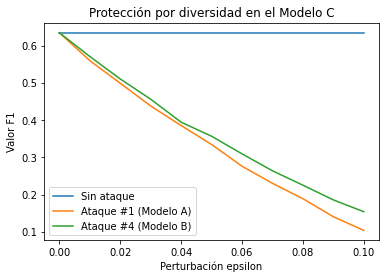

In [24]:
array_original = []
array_attack_1 = []
array_attack_4 = []
array_epsilon = []
relative_error_c_1 = []
relative_error_c_4 = []

for i in range(1,11):
    epsilon = 0.01*i
    loss_object = tf.keras.losses.binary_crossentropy
    array_adversarial_x = np.array
    signed_grad = create_adversarial_pattern(tf.convert_to_tensor(array_test_x),
                                           tf.convert_to_tensor(array_test_y), model_a)
    temp = array_test_x + epsilon*signed_grad
    data_adversarial_x = temp.numpy()
    
    y_pred = modelo_c.predict(data_adversarial_x.reshape(800,4455))
    
    accuracy = accuracy_score(array_test_y.reshape(800), y_pred)
    precision = precision_score(array_test_y.reshape(800), y_pred, average="macro")
    recall = recall_score(array_test_y.reshape(800), y_pred, average="macro")
    score_f1 = f1_score(array_test_y.reshape(800), y_pred, average="macro")
    relative_error = (score_f1 - modelo_c_score_f1)/modelo_c_score_f1

    array_attack_1.append(score_f1) 
    array_epsilon.append(epsilon)
    array_original.append(modelo_c_score_f1)
    relative_error_c_1.append(relative_error)

for i in range(1,11):
    epsilon = 0.01*i
    loss_object = tf.keras.losses.poisson
    array_adversarial_x = np.array
    signed_grad = create_adversarial_pattern(tf.convert_to_tensor(array_test_x),
                                           tf.convert_to_tensor(array_test_y), model_b)
    temp = array_test_x + epsilon*signed_grad
    data_adversarial_x = temp.numpy()
    
    y_pred = modelo_c.predict(data_adversarial_x.reshape(800,4455))
    
    accuracy = accuracy_score(array_test_y.reshape(800), y_pred)
    precision = precision_score(array_test_y.reshape(800), y_pred, average="macro")
    recall = recall_score(array_test_y.reshape(800), y_pred, average="macro")
    score_f1 = f1_score(array_test_y.reshape(800), y_pred, average="macro")
    relative_error = (score_f1 - modelo_c_score_f1)/modelo_c_score_f1

    array_attack_4.append(score_f1)
    relative_error_c_4.append(relative_error)
    
#Modelo C
array_original.insert(0,modelo_c_score_f1)
array_attack_1.insert(0,modelo_c_score_f1)
array_attack_4.insert(0,modelo_c_score_f1)
array_epsilon.insert(0,0)
plt.plot(array_epsilon,array_original , label='Sin ataque')
plt.plot(array_epsilon,array_attack_1 , label='Ataque #1 (Modelo A)')
plt.plot(array_epsilon,array_attack_4 , label='Ataque #4 (Modelo B)')
plt.xlabel("Perturbación epsilon")
plt.ylabel("Valor F1")
plt.title("Protección por diversidad en el Modelo C")
plt.legend()
plt.show()

In [25]:
#Se agrega como origen 0,0 - Equivalente a epsilon igual a cero
relative_error_a_1.insert(0,0)
relative_error_a_2.insert(0,0)
relative_error_b_3.insert(0,0)
relative_error_b_4.insert(0,0)
relative_error_c_1.insert(0,0)
relative_error_c_4.insert(0,0)

#Se invierte el signo para mejorar su comprension en los graficos
relative_error_a_1 = [x*-1 for x in relative_error_a_1]
relative_error_a_2 = [x*-1 for x in relative_error_a_2]
relative_error_b_3 = [x*-1 for x in relative_error_b_3]
relative_error_b_4 = [x*-1 for x in relative_error_b_4]
relative_error_c_1 = [x*-1 for x in relative_error_c_1]
relative_error_c_4 = [x*-1 for x in relative_error_c_4]

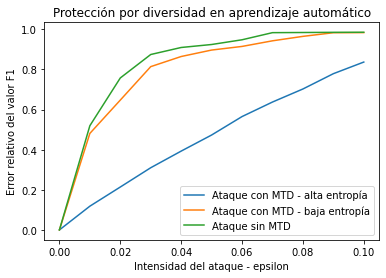

In [29]:
plt.plot(array_epsilon,relative_error_c_1 , label='Ataque con MTD - alta entropía')
plt.plot(array_epsilon,relative_error_a_2 , label='Ataque con MTD - baja entropía')
plt.plot(array_epsilon,relative_error_a_1, label='Ataque sin MTD')
plt.xlabel("Intensidad del ataque - epsilon")
plt.ylabel("Error relativo del valor F1")
plt.title("Protección por diversidad en aprendizaje automático")
plt.legend()
plt.show()

#  Como afecta la magnitud de epsilon a la intensidad del ataque?

## Con epsilon igual a 0.01

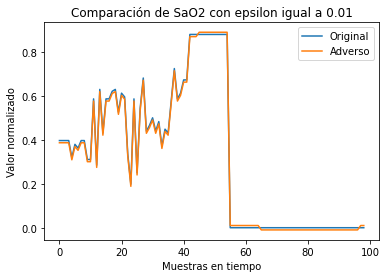

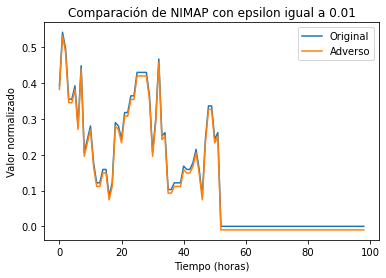

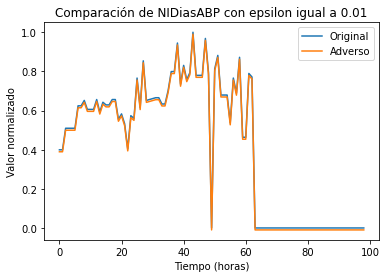

In [27]:
loss_object = tf.keras.losses.binary_crossentropy
array_adversarial_x = np.array
epsilon = 0.01
signed_grad = create_adversarial_pattern(tf.convert_to_tensor(array_test_x),
                                       tf.convert_to_tensor(array_test_y), model_a)

temp = array_test_x + epsilon*signed_grad
data_adversarial_x_attack_1 = temp.numpy()

original = array_test_x
adverse = data_adversarial_x_attack_1

#SaO2
plt.plot(original[2,:,37], label='Original')
plt.plot(adverse[2,:,37], label='Adverso')
plt.xlabel("Muestras en tiempo")
plt.ylabel("Valor normalizado")
plt.title("Comparación de SaO2 con epsilon igual a "+ str(epsilon))
plt.legend()
plt.show()

#NIMAP
plt.plot(original[5,:,30], label='Original')
plt.plot(adverse[5,:,30], label='Adverso')
plt.xlabel("Tiempo (horas)")
plt.ylabel("Valor normalizado")
plt.title("Comparación de NIMAP con epsilon igual a "+ str(epsilon))
plt.legend()
plt.show()

#NIDiasABP
plt.plot(original[8,:,29], label='Original')
plt.plot(adverse[8,:,29], label='Adverso')
plt.xlabel("Tiempo (horas)")
plt.ylabel("Valor normalizado")
plt.title("Comparación de NIDiasABP con epsilon igual a "+ str(epsilon))
plt.legend()
plt.show()

## Con epsilon igual a 0.1

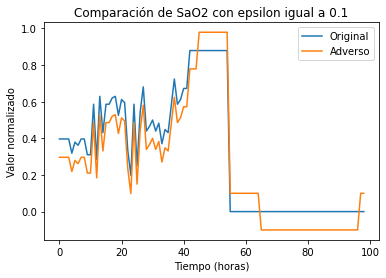

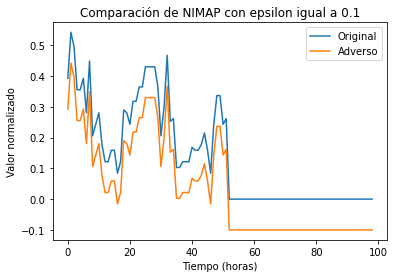

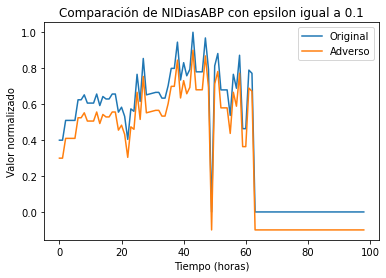

In [28]:
loss_object = tf.keras.losses.binary_crossentropy
array_adversarial_x = np.array
epsilon = 0.1
signed_grad = create_adversarial_pattern(tf.convert_to_tensor(array_test_x),
                                       tf.convert_to_tensor(array_test_y), model_a)

temp = array_test_x + epsilon*signed_grad
data_adversarial_x_attack_1 = temp.numpy()

original = array_test_x
adverse = data_adversarial_x_attack_1

#SaO2
plt.plot(original[2,:,37], label='Original')
plt.plot(adverse[2,:,37], label='Adverso')
plt.xlabel("Tiempo (horas)")
plt.ylabel("Valor normalizado")
plt.title("Comparación de SaO2 con epsilon igual a "+ str(epsilon))
plt.legend()
plt.show()

#NIMAP
plt.plot(original[5,:,30], label='Original')
plt.plot(adverse[5,:,30], label='Adverso')
plt.xlabel("Tiempo (horas)")
plt.ylabel("Valor normalizado")
plt.title("Comparación de NIMAP con epsilon igual a "+ str(epsilon))
plt.legend()
plt.show()

#NIDiasABP
plt.plot(original[8,:,29], label='Original')
plt.plot(adverse[8,:,29], label='Adverso')
plt.xlabel("Tiempo (horas)")
plt.ylabel("Valor normalizado")
plt.title("Comparación de NIDiasABP con epsilon igual a "+ str(epsilon))
plt.legend()
plt.show()